<a href="https://colab.research.google.com/github/jiku100/2020-2-machine-running-proejct/blob/master/assignment9/%EC%8B%A0%EC%84%9D%EA%B2%BD_assignment_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification for Multiple Categories using Pytorch**



# 1. Import library
<hr>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


# 2. Load Data
<hr>

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

In [4]:
data_path = './MNIST'

training_set = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
testing_set = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
batch_32 = 32
batch_64 = 64
batch_128 = 128
learning_rate_value = 1e-2

In [6]:
train_loader_32 = DataLoader(dataset = training_set, batch_size = batch_32, shuffle = True) ## batch size 32 짜리 train loader 생성
test_loader_32 = DataLoader(dataset = testing_set, batch_size = batch_32, shuffle = True) ## batch size 32 짜리 test loader 생성

train_loader_64 = DataLoader(dataset = training_set, batch_size = batch_64, shuffle = True) ## batch size 64 짜리 train loader 생성
test_loader_64 = DataLoader(dataset = testing_set, batch_size = batch_64, shuffle = True) ## batch size 64 짜리 test loader 생성

train_loader_128 = DataLoader(dataset = training_set, batch_size = batch_128, shuffle = True) ## batch size 128 짜리 train loader 생성
test_loader_128 = DataLoader(dataset = testing_set, batch_size = batch_128, shuffle = True) ## batch size 128 짜리 test loader 생성



Target: 1


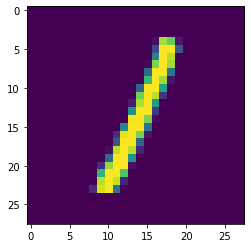

In [7]:
for X, Y in train_loader_64:
  plt.imshow(X[0][0].numpy())
  print(f"Target: {Y[0]}")
  break

# 3. Define Model
<hr>

In [8]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=20*20),
            nn.Sigmoid(),
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=20*20, out_features=10*10),
            nn.Sigmoid(),
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=10*10, out_features=10),
            nn.LogSoftmax(dim=1),
        ) 
        
        
    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out


In [9]:
classifier_32 = classification().to(device)
classifier_64 = classification().to(device)
classifier_128 = classification().to(device)

In [10]:
## Loss function
criterion = nn.NLLLoss()

# Optimization
optimizer_32 = torch.optim.SGD(classifier_32.parameters(), lr=learning_rate_value)
optimizer_64 = torch.optim.SGD(classifier_64.parameters(), lr=learning_rate_value)
optimizer_128 = torch.optim.SGD(classifier_128.parameters(), lr=learning_rate_value)

# 4. Training
<hr>

In [11]:
training_epochs = 60
total_batch_32 = len(train_loader_32)
total_batch_64 = len(train_loader_64)
total_batch_128 = len(train_loader_128)

In [12]:
print(total_batch_64)

938


In [13]:
def accuracy(log_pred, y_true):
    y_pred = torch.argmax(log_pred, dim=1)
    return (y_pred == y_true).to(torch.float).mean()

In [14]:
for X, Y in train_loader_32:
  X = X.to(device)
  Y = Y.to(device)
  pred = classifier_32(X)
  print(torch.argmax(pred, dim=1))
  print(Y)
  print((torch.argmax(pred, dim=1) == Y).to(torch.float).mean())
  break

tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0')
tensor([5, 9, 7, 0, 8, 9, 6, 9, 2, 5, 4, 1, 4, 3, 5, 9, 1, 5, 6, 9, 8, 3, 4, 6,
        6, 2, 8, 8, 2, 3, 5, 4], device='cuda:0')
tensor(0.0625, device='cuda:0')


In [15]:
def training(model, loss, optim, training_epochs, train_loader, test_loader):
  L_iters_train = []
  accuracy_train = []
  L_iters_test = []
  accuracy_test = []
  for epoch in range(training_epochs):
    total_cost_train = 0
    total_cost_test = 0
    total_acc_train = 0
    total_acc_test = 0

    for X, Y in train_loader:
      X = X.to(device)
      Y = Y.to(device)

      optim.zero_grad()
      train_pred = model(X)
      cost = loss(train_pred, Y)
      cost.backward()
      optim.step()
      total_cost_train += cost
      total_acc_train += accuracy(train_pred, Y)
      
    avg_cost_train = total_cost_train / len(train_loader)
    avg_acc_train = total_acc_train / len(train_loader)

    L_iters_train.append(avg_cost_train)
    accuracy_train.append(avg_acc_train)
    with torch.no_grad():
      for X_test, Y_test in test_loader:
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)
        test_pred = model(X_test)
        cost_test = loss(test_pred, Y_test)
        total_cost_test += cost_test
        total_acc_test += accuracy(test_pred, Y_test)
      avg_cost_test = total_cost_test / len(test_loader)
      avg_acc_test = total_acc_test / len(test_loader)
    
      accuracy_test.append(avg_acc_test)
      L_iters_test.append(avg_cost_test)

    print("Epoch: %02d Training Loss: %.9f Testing Loss: %.9f  Training Acc: %.9f Testing Acc: %.9f" %((epoch + 1),avg_cost_train, avg_cost_test, avg_acc_train, avg_acc_test))
  return L_iters_train, accuracy_train, L_iters_test, accuracy_test

In [16]:
L_train_32, A_train_32, L_test_32, A_test_32 = training(classifier_32, criterion, optimizer_32, training_epochs, train_loader_32, test_loader_32)

Epoch: 01 Training Loss: 2.144883394 Testing Loss: 1.768218637  Training Acc: 0.322916657 Testing Acc: 0.508286715
Epoch: 02 Training Loss: 1.262552381 Testing Loss: 0.902980387  Training Acc: 0.646466672 Testing Acc: 0.768570244
Epoch: 03 Training Loss: 0.744534373 Testing Loss: 0.600973248  Training Acc: 0.806699991 Testing Acc: 0.843750000
Epoch: 04 Training Loss: 0.538277686 Testing Loss: 0.465664685  Training Acc: 0.859883368 Testing Acc: 0.875798702
Epoch: 05 Training Loss: 0.442839146 Testing Loss: 0.397838533  Training Acc: 0.881116688 Testing Acc: 0.890075862
Epoch: 06 Training Loss: 0.391405344 Testing Loss: 0.360379934  Training Acc: 0.891833365 Testing Acc: 0.899660528
Epoch: 07 Training Loss: 0.358887255 Testing Loss: 0.335996509  Training Acc: 0.900049984 Testing Acc: 0.906050324
Epoch: 08 Training Loss: 0.336116433 Testing Loss: 0.316255450  Training Acc: 0.904900014 Testing Acc: 0.909744382
Epoch: 09 Training Loss: 0.318039209 Testing Loss: 0.300507426  Training Acc: 0.

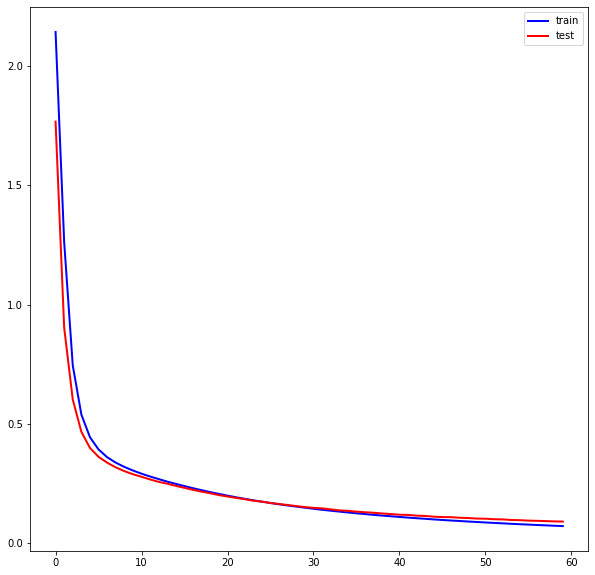

In [17]:
plt.figure(figsize = (10,10))
plt.plot(L_train_32, linewidth = 2, c='b', label = "train")
plt.plot(L_test_32, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

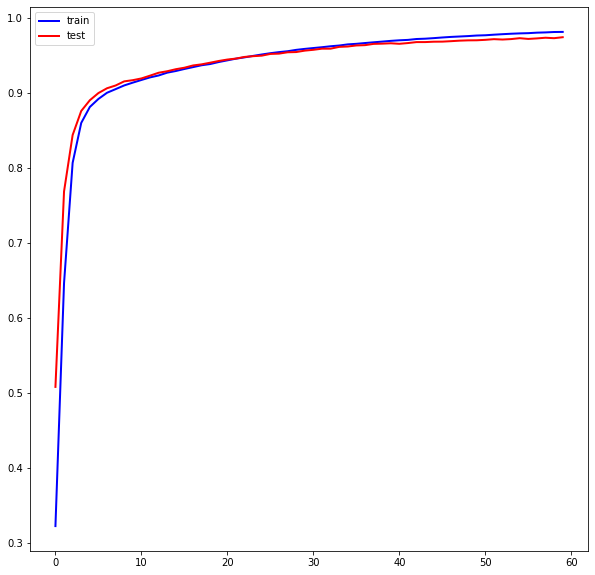

In [18]:
plt.figure(figsize = (10,10))
plt.plot(A_train_32, linewidth = 2, c='b', label = "train")
plt.plot(A_test_32, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

In [19]:
L_train_64, A_train_64, L_test_64, A_test_64 = training(classifier_64, criterion, optimizer_64, training_epochs, train_loader_64, test_loader_64)

Epoch: 01 Training Loss: 2.266192436 Testing Loss: 2.212422848  Training Acc: 0.214952037 Testing Acc: 0.409633756
Epoch: 02 Training Loss: 2.069086790 Testing Loss: 1.823312759  Training Acc: 0.470215887 Testing Acc: 0.530354321
Epoch: 03 Training Loss: 1.520716906 Testing Loss: 1.245139480  Training Acc: 0.597231507 Testing Acc: 0.666500807
Epoch: 04 Training Loss: 1.077415228 Testing Loss: 0.924537718  Training Acc: 0.715734959 Testing Acc: 0.759255588
Epoch: 05 Training Loss: 0.833771765 Testing Loss: 0.733340263  Training Acc: 0.780217230 Testing Acc: 0.808718145
Epoch: 06 Training Loss: 0.681983709 Testing Loss: 0.613703668  Training Acc: 0.819313049 Testing Acc: 0.837579608
Epoch: 07 Training Loss: 0.585026205 Testing Loss: 0.533548415  Training Acc: 0.842184186 Testing Acc: 0.855593145
Epoch: 08 Training Loss: 0.520377517 Testing Loss: 0.478680372  Training Acc: 0.859858096 Testing Acc: 0.869128227
Epoch: 09 Training Loss: 0.474326909 Testing Loss: 0.442339778  Training Acc: 0.

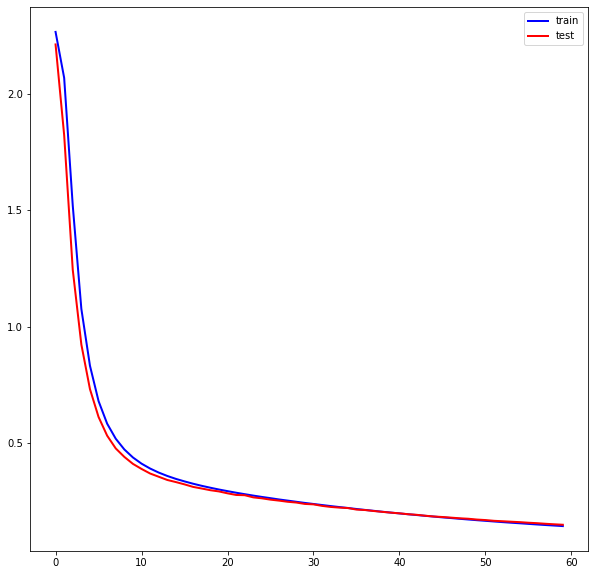

In [20]:
plt.figure(figsize = (10,10))
plt.plot(L_train_64, linewidth = 2, c='b', label = "train")
plt.plot(L_test_64, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

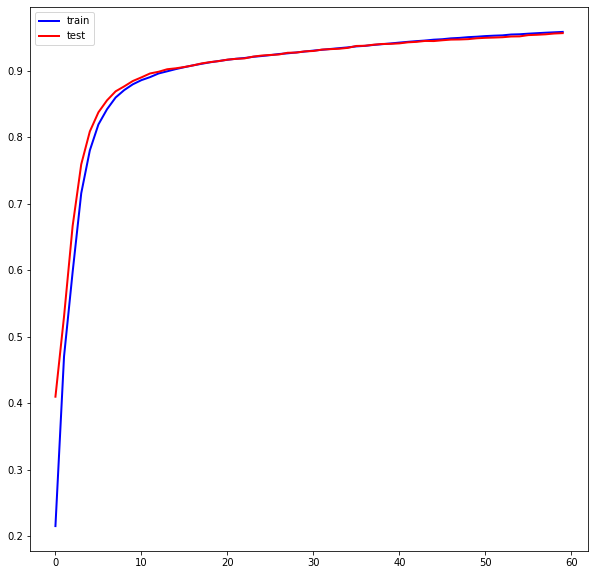

In [21]:
plt.figure(figsize = (10,10))
plt.plot(A_train_64, linewidth = 2, c='b', label = "train")
plt.plot(A_test_64, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

In [22]:
L_train_128, A_train_128, L_test_128, A_test_128 = training(classifier_128, criterion, optimizer_128, training_epochs, train_loader_128, test_loader_128)

Epoch: 01 Training Loss: 2.288439989 Testing Loss: 2.267014980  Training Acc: 0.127959535 Testing Acc: 0.120154276
Epoch: 02 Training Loss: 2.243486166 Testing Loss: 2.210860491  Training Acc: 0.282549322 Testing Acc: 0.428401917
Epoch: 03 Training Loss: 2.158898830 Testing Loss: 2.083311558  Training Acc: 0.454851866 Testing Acc: 0.467464417
Epoch: 04 Training Loss: 1.967103958 Testing Loss: 1.814421654  Training Acc: 0.506463230 Testing Acc: 0.526305377
Epoch: 05 Training Loss: 1.655637264 Testing Loss: 1.492081046  Training Acc: 0.571856141 Testing Acc: 0.608979464
Epoch: 06 Training Loss: 1.361608028 Testing Loss: 1.230768681  Training Acc: 0.641035914 Testing Acc: 0.677709699
Epoch: 07 Training Loss: 1.140764713 Testing Loss: 1.045940042  Training Acc: 0.697189331 Testing Acc: 0.716969967
Epoch: 08 Training Loss: 0.979527116 Testing Loss: 0.906365991  Training Acc: 0.740927041 Testing Acc: 0.765031636
Epoch: 09 Training Loss: 0.859164238 Testing Loss: 0.800153792  Training Acc: 0.

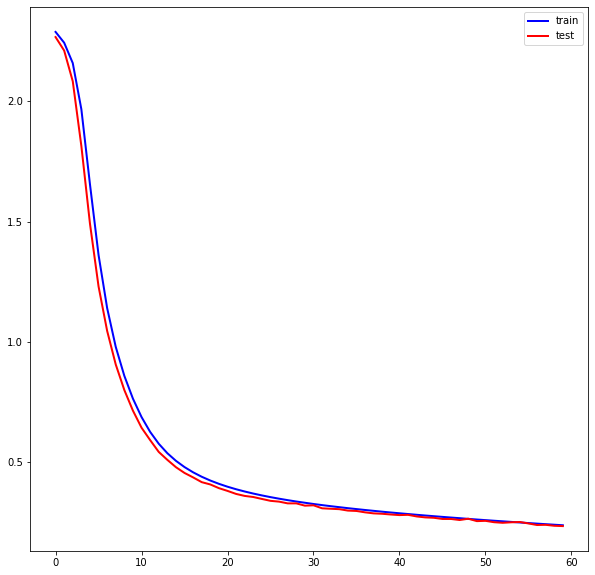

In [24]:
plt.figure(figsize = (10,10))
plt.plot(L_train_128, linewidth = 2, c='b', label = "train")
plt.plot(L_test_128, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

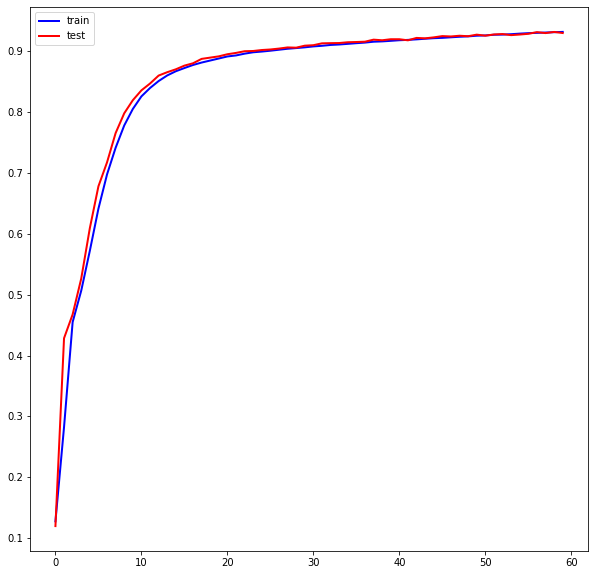

In [25]:
plt.figure(figsize = (10,10))
plt.plot(A_train_128, linewidth = 2, c='b', label = "train")
plt.plot(A_test_128, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

# 5. Output
<hr>

## 1. Plot the training and testing losses with a batch size of 32

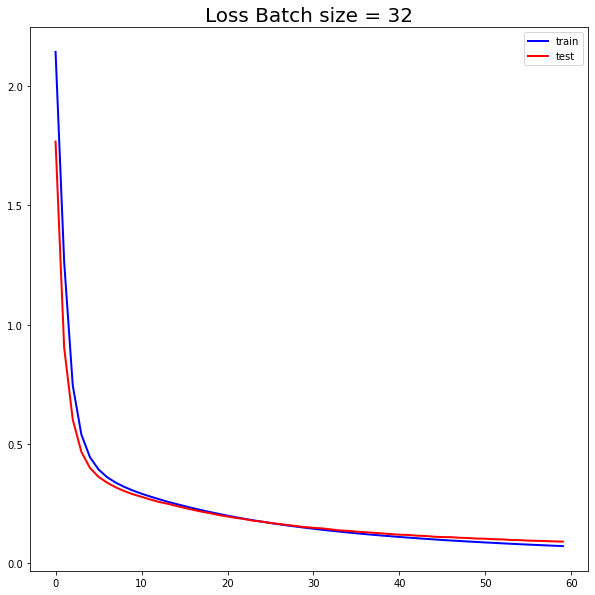

In [27]:
plt.figure(figsize = (10,10))
plt.title("Loss Batch size = 32", fontsize = 20)
plt.plot(L_train_32, linewidth = 2, c='b', label = "train")
plt.plot(L_test_32, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()